# 0. **Introduction**

## 0.0 **Setup** (dont read, just run)

In [1]:
from utils import ModelConfig, Graph, get_dataloader
from utils.interp import *
from models import get_model

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import networkx as nx
import torch
from torch import Tensor
import einops
from jaxtyping import Float
import numpy as np
import rich
from rich.table import Table
from tqdm.auto import tqdm

import yaml

## 0.1 **Aim**

Inspired by [Neel Nanda's modular addition paper](https://arxiv.org/pdf/2301.05217), I wanted to train a toy model to do a mathematical algorithm and use mechanistic interpretability techniques to attempt to reverse engineer as much of the model as possible. I needed a task simple enough that I could train a toy model to achieve good performance but complex enough that there would be non-trivial computation to discover within the model. I settled on the task of *classifying graphs by their planarity*.

The purpose of this notebook is to follow my thought process and key results as I attempt to achieve this aim. There are interactive visualisations along the way so that you yourself can make the same discoveries that I did (and maybe even make some more!?). For people less familiar with mech interp, this process can serve as a hands-on introduction to some key methods for analysing models. For people with a bit more experience, this is a fun way to get straight into analysing a novel toy model and practice your mech interp skills!

The only real prerequesite is a basic understanding of how transformers work (attention heads, the residual stream etc.). If at any point you feel like you are missing some architectural intuition, then I recommend taking a look at the "Transformer Overview" section of [this paper] (https://transformer-circuits.pub/2021/framework/index.html)(although be careful to note any differences in notation between the paper and the notation I define in section 0.3).

## 0.2 **The Task**

A *graph* is a collection of vertices with edges connecting pairs of those vertices.

We say vertices $i$ and $j$ are *adjacent* if there is an edge connecting them.

If a vertex is adjacent to $d$ other vertices then we say it has *degree $d$*.

We can uniquely specify a graph with its *adjacency matrix* $X$ defined as follows:

$X_{ij}=\begin{cases}1 \quad\text{if } i \text{ and } j \text{ are adjacent} \\0 \quad\text{otherwise}\end{cases}$

The `Graph` class holds both the adjacency matrix and the [NetworkX](https://networkx.org/) representation of a graph in a single python object, allowing us to easily create, manipulate and visualise our own graphs.

tensor([[[0., 0., 1., 0., 0., 1., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 1., 1., 1.],
         [1., 0., 0., 1., 0., 1., 0., 0., 0., 1.],
         [0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 1., 0., 0.],
         [1., 1., 1., 0., 1., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
         [0., 1., 0., 1., 1., 0., 0., 0., 1., 1.],
         [0., 1., 0., 0., 0., 0., 1., 1., 0., 0.],
         [0., 1., 1., 0., 0., 0., 1., 1., 0., 0.]]])


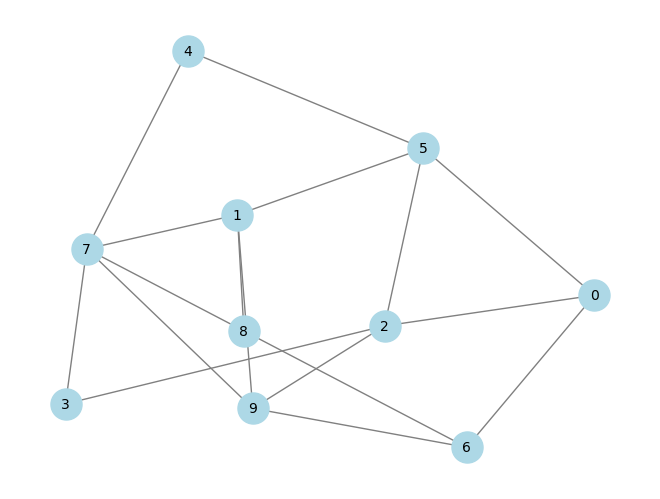

In [2]:
n_vertices = 10
n_edges = 17

random_graph = Graph(nx.gnm_random_graph(n_vertices,n_edges))

print(random_graph.X)
random_graph.plot()

A graph is *planar* if you can draw it in the plane without any of its edges crossing. We call such a drawing a *planar embedding*.

Is the graph we just plotted planar? In many cases it is not immediately obvious from the plot&mdash;just becuase the plot we see has crossing edges doesn't mean we can't rearrange the vertices so that no edges cross.

Algorithms to determine the planarity of a graph do exist:

In [3]:
is_planar, certificate = nx.check_planarity(random_graph.G)
print("This graph {} planar".format("is" if is_planar else "isn't"))
if is_planar:
    print("Here is a planar embedding of the graph:")
    random_graph.plot(pos = nx.combinatorial_embedding_to_pos(certificate))

This graph isn't planar


This means we can create a dataset of graphs labelled with their planarity and train a model to classify graphs based on this label.

## 0.3 **The Model**

*Disclaimer: A few of the design choices in this section are not particularly principled. The aim wasn’t to create the best model for the task, it was to train a model that achieved decent accuracy by doing some non trivial computation related to the task that I could hopefully reverse engineer.*

The toy architecure that I used was a two layer decoder-only transformer with 8 attention heads per layer and a 128 dimensional residual stream.

$n_{heads} = 8, d_{model} = 128$

I used a dataset of ~100k adjacency matrices of graphs on 10 vertices.

<details>
    <summary> Dataset generation details, feel free to skip! </summary>
The dataset was generated as follows:

- Let $s$ be the desired size of the dataset and let $M = \{15,16,...,20\}$ be the set of edge counts.
- For each $m$ in $M$, generate random graphs with $m$ edges until you have $s/2|M|$ planar graphs and $s/2|M|$ non-planar graphs.

The reason to ensure a 50-50 split of planar and non-planar graphs across all $m$ values is because the probaility that a random graph (generated without forcing a 50-50 split) is planar is correlated to $m$. This means the model could use $m$ as a heuristic and classify based purely on that, not learning any computation fundementally related to planar graphs. Therefore I decided to prevent this possibility.

The reason to use $M = \{15,16,...,20\}$ is because outside of this range the probability a random graph is planar is either very close to 0 or 1 so it is harder to generate $s/2|M|$ of both types. The model trained ends up having little problem generalising to outside this range.
</details>

Each adjacency matrix, $X$, (with shape $(10, 10)$) is embedded using matrices  $W_E$ (shape $(10, 128)$) and $W_{pos}$ (shape $(10, 128)$) as follows:

$x_0 = XW_E + W_{pos},$

where $x_i$ is the residual stream after $i$ layers of the model. We refer to $XW_E$ as the contribution from the *Embed* and $W_{pos}$ as the contribution from the *PosEmbed*. Effectively, each vertex position in the residual stream pre layer 0, $x_0$, starts as the sum of the embeddings of its adjacent vertices (“looked up” in the $W_E$) as well as its own positional embedding from $W_{pos}$.

The model outputs logits by mean pooling all positions in the residual stream, $x_2$, together into a 128 dimensional vector and then right multiplying by $W_U$ (shape $(128, 2)$)

The trained model achieved 99.9% validation accuracy. I compared this with a few simpler architectures (e.g. mlp, see dropdown) to test whether my toy model was needlessly complex and concluded that the architecture did actually help with performance. Hopefully this means there is some non trivial computation to discover.

<details>
    <summary>Model training curves</summary>

Comparing the training curves for my model with simpler alternatives suggests that my model has some sophisticated computation for us to discover.

<img src="https://github.com/jamie-stephenson/graph-interp/blob/main/images/train_curve.png?raw=True" width="800">
</details>


We are nearly ready to start interpreting the model! All that is left to do is load the model in and test it on a few examples to demonstrate that it is working properly.

**Load Model**

In [4]:
path = 'trained_models/transformer_2024-09-05_13-28-07'

with open(path+'.yaml','r') as file:
    args = yaml.safe_load(file)

args['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'
model = get_model(args)
model.eval()
state_dict = torch.load(path+'.pt',map_location=model.cfg.device, weights_only=True)
model.load_state_dict(state_dict)


<All keys matched successfully>

**Test model on val set and random graphs**

In [ ]:
loader = get_dataloader('data/n10_15-21_tn_vn/val.npz',1)
n_planar = n_correct = 0
for x,y in loader:
    x, y = x.to(model.cfg.device), y.to(model.cfg.device)
    logits = model(x)
    correct = logits.argmax()==y
    n_planar += y.item()*correct
    n_correct += correct

print(f"Val Set Accuracy: {(100*n_correct/len(loader)).item():.2f}%")
print(f"{(100*n_planar/n_correct).item():.2f}% of correctly classified graphs were planar.")
print()

n_samples = 1000
performace_table = Table(title='Model performance on random graphs:')
performace_table.add_column('Number of edges',justify='center')
performace_table.add_column(f'Percentage of {n_samples} random graphs correctly classified',justify='right')
performace_table.add_column('Percentage of correctly classified graphs that were planar',justify='right')

for m in range(10,25,3):
    n_planar = n_correct = 0
    for _ in range(n_samples):
        g = Graph(nx.gnm_random_graph(model.cfg.n_vertices,m))
        y = nx.is_planar(g.G)
        logits = model(g.X.to(model.cfg.device))
        correct = logits.argmax().detach()==y
        n_planar += y*correct
        n_correct += correct
    performace_table.add_row(str(m),f"{(100*n_correct/n_samples).item():.2f}",f"{(100*n_planar/n_correct).item():.2f}")

rich.print(performace_table)


# 1. **Identifying a Circuit**

## 1.0 **Cache activations from example graphs**

The first thing we need to do is run a few example inputs through the model and cache the activations so that we can visualise what the model is doing to each input. The examples we use are: a few famous graphs, a batch of graphs from the validation set and the random graph we looked at earlier.

In [5]:
petersen_graph = Graph(nx.petersen_graph())
cycle_graph = Graph(nx.cycle_graph(model.cfg.n_vertices))
complete_graph = Graph(nx.complete_graph(model.cfg.n_vertices))
empty_graph = Graph(nx.empty_graph(model.cfg.n_vertices))
star_graph = Graph(nx.star_graph(model.cfg.n_vertices-1))

loader = get_dataloader('data/n10_15-21_tn_vn/val.npz',1024)
batch,batch_labels = next(iter(loader))

model.set_use_attn_result(True)
_, random_cache = model.run_with_cache(random_graph.X.to(model.cfg.device))
_, petersen_cache = model.run_with_cache(petersen_graph.X.to(model.cfg.device))
_, cycle_cache = model.run_with_cache(cycle_graph.X.to(model.cfg.device))
_, complete_cache = model.run_with_cache(complete_graph.X.to(model.cfg.device))
_, empty_cache = model.run_with_cache(empty_graph.X.to(model.cfg.device))
_, star_cache = model.run_with_cache(star_graph.X.to(model.cfg.device))
_, batch_cache = model.run_with_cache(batch.to(model.cfg.device))
model.set_use_attn_result(False)

In [ ]:
n_planar = 0
for g in batch:
    graph = Graph(g)
    n_planar += nx.is_planar(graph.G)
print(f"{100*n_planar/len(batch):.2f}% of the batch are planar graphs.")

## 1.1 **Plot attention patterns**

We begin by looking at the attention patterns for specific inputs to the model. In the case of our model, attention patterns $A^h$ are 10 by 10 matrices that represent how each attention head $h$ moves information between the vertex positions of the input graph. For instance, if $A_{ij}^{1.3}$ is large, that means that head 1.3 moves lots of information from vertex position $j$ to vertex position $i$. We say that vertex position $i$ *attends strongly* to vertex postion $j$.

I took the usual [CircuitsVis](https://github.com/TransformerLensOrg/CircuitsVis) way of visualising language model attention patterns (in which you visualise which tokens in an input sentence attend to each other by shading the tokens themselves) and applied it to graph inputs. This results in a visualisation in which you can select an attention pattern and hover over a vertex to see which other vertices it attends to.

It is important to remember that transformers are designed so that the attention patterns in each attention head *depend on the input*. Indeed, if we rename all the vertices of a graph but keep all the edges the same, we still want the vertices to attend to each other in the same way and so the model must adjust its attention patterns accordingly. It is therefore important to study the attention patterns for a whole range of input graphs. This way you can get a much better idea of what each head could be doing.

Have a go yourself at looking at the attention patterns for different input graphs. The example below is for the attention patterns in layer 0 for a randomly generated graph, but you can change the layer and swap in any of the graphs that we cached during section 1.0.

<details>
    <summary>How to use this visualisation</summary>

- Select the layer (0 or 1) of the model by changing the `layer` variable below.
- Select the graph input by changing the `graph` and `cache` variables (e.g. try `graph=petersen_graph` and `cache=petersen_cache`).
- Run the cell.
- Select a head $h$ by clicking on one of the attention patterns $A^h$. This "applies" this attention pattern to the graph plot.
- Hover over vertex $i$ in the graph to visualise the value $A^h_{ij}$ on every vertex $j$ in the graph. This allows us to see all the vertices in the graph from vertex $i$'s "perspective".
</details>

In [6]:
layer = 1
graph = random_graph
cache = random_cache

graph.plot_attention(cache["pattern",layer].cpu())

**Observation**: In Head 1.6, vertices of low degree attend stongly to vertex position 2. Let's try and work out how the model does this.

My first guess as to how this attention pattern in head 1.6 comes about is:
- Each vertex of low degree has the concept of "I am a vertex of low degree" encoded in its residual stream position.
- The query matrix for head 1.6 reads this information from the residual stream and produces queries that encode the concept "I am looking for the special vertex position" in low degree vertex positions.
- The key matrix for head 1.6 produces a key that says "I am in the special vertex position" in position 2.

## 1.2 **Patching**

Let's test this theory by looking at how earlier components contribute to the attention score in head 1.6.

We are going to take a "corrupted" graph with (in some sense) no low degree vertices as model input and then "patch over" the paths leading from a collection of earlier components to the query and/or the key of head 1.6 using the cached head 0.2 activations for a "clean" graph with some low degree vertices. This will allow us to see to what extent we can reproduce the "clean" behaviour of head 1.6 using only a subset of the components earlier in the model. We can use this to test my theory that degree information is passed into head 1.6 via the query and the positional information pinpointing vertex position 2 is passed in via the key. We should be able to go one step further and actually identify which earlier components are responsible for passing this information on to head 1.6. If we can find a subset of the model's components that are responsible for this then we will have identified the *circuit* responsible for head 1.6's function.

By "components" I mean attention heads and the embedding.

By "path" I mean the sequence of latent variables that lead from a component directly (without involving another component) to another component later in the model (in this case head 1.6).
"Patching over" a path from component $A$ to component $B$ means effectively replacing all these latent varaibles with what they would be in the hypothetical scenario that component $A$'s output was replaced but all other components outputs stayed the same (even for components that come after $A$ in the model). By doing this we can get a better idea of the extent to which $A$ helps $B$ achieve its function.

Notice that I choose not to include the mlps as components. Instead, we say that mlps count as part of the direct path between other components. This is because (in the case of this specific circuit) it turns out that all the important paths between other components go through the mlp on layer 0. Insisting on studying paths that skip the mlp obscures important relationships that depend on mlp computation.  

Because you can't in general simultaneously patch two different paths during the same forward pass, we implement the above as follows:
1. Choose two subsets of the components that come before head 1.6 in the model (i.e. Embed, Layer 1 heads)
2. Input a "corrupted" graph into the model
3. Replace only the output of the components within our first chosen subset with the equivalent output obtained when the "clean" graph is the input.
4. Continue the model forward pass and cache the query of head 1.6.
5. Begin another forward pass on the same corrupted output and this time replace only the output of the components within our *second* chosen subset.
6. Continue the forward pass until layer 1 and replace the query in head 1.6 with the cached query from the previous run.
7. Observe the resulting attention pattern in head 1.6 and hopefully pinpoint which components are needed to reproduce the "clean" attention pattern and in what way they compose with head 1.6.

This is a specific implementation of a broader technique known as *path patching*. In the cells below we carry out path patching with the following configuration details:
- `q_heads_to_patch` specifies heads $h$ for which the path from $h$ to the query of head 1.6 will be patched.
- `q_patch_embed` specifies whether or not to patch the path from the Embed to the query of head 1.6.
- `k_heads_to_patch` specifies heads $h$ for which the path from $h$ to the key of head 1.6 will be patched.
- `k_patch_embed` specifies whether or not to patch the path from the Embed to the key of head 1.6.

Have a play around with this configuration below and see if you can gain some insight that could help with step 7 above.

<details>
  <summary>More on patching</summary>
  
A more complete explanation of patching can be found by first reading about general [activation patching](https://dynalist.io/d/n2ZWtnoYHrU1s4vnFSAQ519J#z=qeWBvs-R-taFfcCq-S_hgMqx) and then [path patching](https://dynalist.io/d/n2ZWtnoYHrU1s4vnFSAQ519J#z=M3vTmlndMJTgnL1-t1IAsTaR&q=path%20patching).
  
</details>

<details>
  <summary>Two things to note</summary>
  
PosEmbed is the same for all inputs so patching it in this scenario is pointless.

The cell below runs path patching for several example configurations and, as such, the four variables described above are actually lists with the $i^{th}$ entry of each forming the configuration for the $i^{th}$ path patching example.
  
</details>

In [9]:
corrupted_input = petersen_graph.X.to(model.cfg.device)
corrupted_cache = petersen_cache
clean_input = random_graph.X.to(model.cfg.device)
clean_cache = random_cache

layer_1_head = 6

In [ ]:
# Components to patch:
q_heads_to_patch = [[2],[3,4],[1,2,3]]
q_patch_embed = [False,True,False]
k_heads_to_patch = [[],[2],[1,2,3]]
k_patch_embed = [False,False,False]

component_lists = [q_heads_to_patch,q_patch_embed,k_heads_to_patch,k_patch_embed]

n_examples = len(q_heads_to_patch)

assert all(len(lst) == n_examples for lst in component_lists)

px.imshow(random_cache["pattern",1][0,6].cpu(),color_continuous_scale='Blues',title="Clean Pattern",width=1000).show()
px.imshow(petersen_cache["pattern",1][0,6].cpu(),color_continuous_scale='Blues',title="Corrupted Pattern",zmax=1,width=1000).show()

for i in range(n_examples):
    pattern = get_path_patched_attn_pattern(
        model,
        corrupted_input,
        corrupted_cache,
        clean_input,
        clean_cache,
        q_heads_to_patch = q_heads_to_patch[i],
        q_patch_embed = q_patch_embed[i],
        k_heads_to_patch = k_heads_to_patch[i],
        k_patch_embed = k_patch_embed[i],
        layer_1_head = layer_1_head
    )

    q_heads_string = "heads 0." + ", 0.".join(map(str, q_heads_to_patch[i])) if q_heads_to_patch[i] else ""
    q_embed_string = " Embed and" if q_patch_embed[i] else ""
    q_string = f"{q_embed_string} {q_heads_string} -> query of head 1.6<br>" if q_heads_string or q_embed_string else ""
    k_heads_string = "heads 0." + ", 0.".join(map(str, k_heads_to_patch[i])) if k_heads_to_patch[i] else ""
    k_embed_string = " Embed and" if k_patch_embed[i] else ""
    k_string = f"{k_embed_string} {k_heads_string} -> key of head 1.6<br>" if k_heads_string or k_embed_string else ""
    title = f"Pattern when the following paths are patched:<br>{q_string}{k_string}"

    px.imshow(
        pattern.cpu(),
        color_continuous_scale='Blues',
        title=title,
        zmax=1,
        width=1000
    ).show()

Having played around with the setup above, I made the following observations:
1. I cannot reproduce any of the clean pattern purely by patching paths into the key of head 1.6. This suggests that some important information must be entering head 1.6 via the query. This does not rule out my theory that the information pinpointing vertex position 2 enters head 1.6 via the key (but it doesn't support it either).
2. Configurations involving patching the path from head 0.2 to the query of head 1.6 tend to be the ones that reproduce the clean pattern most closely. This suggests that head 0.2 is passing important information to head 1.6 via the query. We say that head 0.2 is "Q-composing" with head 1.6.
3. In configurations that involve head 0.2 but still miss some key parts of the pattern, adding in heads 0.1, 0.3 and/or Embed can help performance. This suggests more than one head is involved in the circuit responsible for the function of head 1.6. It also suggests that Embed has a direct effect on head 1.6, not just via layer 0 heads.

To be more confident in observations 2 and 3, we can quantify how well the pattern has been reproduced and then repeat the patching process above for all possible configurations and across a whole batch of graphs, recording how well the pattern has been reproduced each time.
When I say "all possible configurations" I am actually ignoring configurations involving patching paths from layer 0 heads to the key of head 1.6. This to reduce the number of possible configurations to a manageable amount. Based on observation 1, I am confident that this does not miss a configuration that offers a notably good reconstruction of the clean attention pattern.

I quantify the pattern reconstuction performance using the `patching_metric` below (scaled so that 1 represents no improvement over the corrupted input and 0 represents perfect reconstruction).

In [ ]:
def patching_metric(
    reconstructed_pattern: Float[Tensor,"batch n_vertices n_vertices"],
    clean_pattern: Float[Tensor,"batch n_vertices n_vertices"],
    corrupted_pattern: Float[Tensor,"batch n_vertices n_vertices"] # batch can be 1 in some cases but broadcasting handles this
):
    return (torch.linalg.matrix_norm(reconstructed_pattern-clean_pattern)/torch.linalg.matrix_norm(clean_pattern-corrupted_pattern)).mean().item()

def get_component_string(results_key):
    """Given key from results dict, return dict expressing which components that key corresponds to."""
    q_components = 'Embed '*results_key[0][0] + ' '.join(f'0.{head}' for head in results_key[0][1:])
    k_components = 'Embed' if results_key[1][0] else ''
    return q_components, k_components

def get_n_components_patched(results_key):
    """Given key from results dict, find total number of components that have been patched"""
    return sum([
        results_key[0][0],
        results_key[1][0],
        len(results_key[0][1:]),
        len(results_key[1][1:])
    ])


results = get_path_patching_metric_results(
    model,
    corrupted_input,
    corrupted_cache,
    batch.to(model.cfg.device),
    batch_cache,
    patching_metric,
    layer_1_head
)

table = Table('Number of components patched','Best Score Achieved','Q Components Patched','K Components Patched',title='Best paths to patch for each number of components patched:')
one_component_table = Table("Q component", "K Component","Pattern Reconstruction Score", title='Results from patching one component')

for n_components_patched in range(1,model.cfg.n_heads+2):
    filtered_results = {k:v for k,v in results.items() if get_n_components_patched(k)==n_components_patched}
    if n_components_patched==1:
        for k,v in filtered_results.items():
            q_component, k_component = get_component_string(k)
            one_component_table.add_row(q_component, k_component,f"{v:.2f}")
    best_combination = min(filtered_results, key=filtered_results.get)
    best_q_components, best_k_components = get_component_string(best_combination)
    best_metric_score = filtered_results[best_combination]
    table.add_row(str(n_components_patched),f"{best_metric_score:.2f}",best_q_components,best_k_components)

rich.print(one_component_table)
rich.print(table)

The results above make me pretty confident that head 0.2 Q-composing with head 1.6 is the main interaction driving the circuit behind head 1.6's function.

Note that we still haven't obtained any evidence supporting my theory that the information pinpointing vertex position 2 enters head 1.6 via the key. While it makes sense the key could have learned to produce a special key vector in position 2 that matches each vector that the query puts in a low degree vertex position, for all we know this information could be passed in via some other less intuitive mechanism.

However, a quick check of the activations in the key of head 1.6 (averaged out across a batch of input graphs) strongly suggests that my theory is correct:

In [ ]:
k = batch_cache['k',1][:,:,6].cpu()
px.imshow(k.mean(0),color_continuous_scale='RdBu',color_continuous_midpoint=0,title="Average key actiavtions for head 1.6").show()

The key clearly knows which position head 1.6 wants to move information from. But how does it know this? From our observations, the choice of position 2 is independent of input and only depends on positional information. Therefore it would make sense if the information comes direct from the PosEmbed.

We can test this with some more path patching. This time instead of patching a path using two different input graphs, we are going to patch the direct path from the positional embedding to the key of head 1.6 with the path that we would observe if the positional embeddings for position 2 and position 0 were swapped. We can then see the effect this has on the resulting attention pattern in head 1.6.

In [ ]:
position_to_swap_with_2 = 0

new_pos_embed = model.W_pos.data.clone()
new_pos_embed[[2,position_to_swap_with_2]] = new_pos_embed[[position_to_swap_with_2,2]]

pattern = get_pos_embed_to_key_path_patched_attn_pattern(
    model,
    input=clean_input,
    cache=clean_cache,
    new_pos_embed=new_pos_embed,
    layer_1_head=layer_1_head
)

title = f"Pattern when the path from PosEmbed to the key of head 1.{layer_1_head}<br>is patched by switching position 2 and position {position_to_swap_with_2}."

px.imshow(
    pattern.cpu(),
    color_continuous_scale='Blues',
    title=title,
    zmax=1,
    width=1000
).show()

Just as we expect, we are able to consistently permute the columns of the head 1.6 pattern simply by permuting the rows of the PosEmbed and only allowing this change to effect head 1.6 via a direct path (not via layer 0 heads). This strongly suggests that the only information relevant to pinpointing position 2 in head 1.6 originates in the PosEmbed and enters the head via the key without any information being moved in between postions. Indeed, the mlp between the layer 0 and layer 1 heads acts positionwise so cannot move information and the attention heads are all effectively "frozen" by the path patching process.  

These results give us a pretty good intial overview of the circuit responsible for the function of head 1.6: the information required to pinpoint position 2 passes directly from the PosEmbed into head 1.6 via the key and the degree information passes from head 0.2 to head 1.6 via the query. A few other layer 0 heads also Q-compose with head 1.6 but are less important.
<details>
    <summary>A diagram to visualise this circuit</summary>

The diagram below shows one way to visualise the circuit in the case that vertex 1 has low degree. Each copy of the model architecture represents the action of the model on a single vertex position in the residual stream. Any lines passing between copies represent information being moved between vertex positions. MLPs and irrelevant attention heads are omitted for simplicity.

<img src="https://github.com/jamie-stephenson/graph-interp/blob/main/images/head16.png?raw=True" width="400">
</details>

## 1.3 **Head 0.2**

Now that we have an initial overview, let's follow this trail back through the model by looking more closely at head 0.2. We will again start by studying the attention pattern.

In [ ]:
random_graph.plot_attention(random_cache['pattern',0].cpu())

**Observation**: Vertices of high degree attend more to vertices 3 and 6, whereas vertices of low degree seem to attend evenly to all vertices.

Although this pattern seems conceptually similar to head 1.6, there are three main differences that I observe:
1. Instead of vertex position 2, vertices attend to vertex positions 3 and 6.
2. Instead of low degree vertices, it is the high degree vertices that attend strongly to the special vertex positions.
3. Instead of seemingly all "low degree" vertices attending maximally to the special vetex position (like in head 1.6), here it seems like attention scales with degree: the higher a vertex's degree, the more strongly it attends to vertex positions 3 and 6.

Based on these observations, I have a similar theory for this heads mechansim as I did for head 1.6: the query receives the degree information and the key receives the positional information required for pinpointing positions 3 and 6.

As before, we will now test this theory. However, now that we are studying a layer 0 head we have two simplifications that we can take advantage of:
1. There are only two inputs to this head: the Embed and PosEmbed.
2. There are no non-linear mlps between us and the model input.

This means we can use some more straight forward techniques to study how the Embed and PosEmbed interact with head 0.2.

Let $X$ be an adjacnecy matrix model input, let $W_Q^h$ and $W_K^h$ be the query and key matrices for head $h$ and let $W_{pos}$ and $W_E$ be the positional embedding and embedding matrices. Then the query $q$ and key $k$ of head 0.2 are given by:

$$q = XW_EW_Q^{0.2}+ W_{pos}W_Q^{0.2}$$

$$k = XW_EW_K^{0.2}+ W_{pos}W_K^{0.2}$$

This means we can nicely decompose $q$ and $k$ into their two terms and quantify how much each one contributes to the result. We will do this by taking the norm of each component of the sum and averaging out across a batch of inputs:

In [ ]:
decomposed_qk_input_layer_0 = decompose_qk_input(model, batch_cache, layer=0)
decomposed_q_layer_0 = decompose_q(model,decomposed_qk_input_layer_0,head_index=2,layer=0)
decomposed_k_layer_0 = decompose_k(model,decomposed_qk_input_layer_0,head_index=2,layer=0)

component_labels_layer_0 = ["Embed", "PosEmbed"]
for decomposed_input, name in [(decomposed_q_layer_0, "query"), (decomposed_k_layer_0, "key")]:
    px.imshow(
        decomposed_input.pow(2).sum(-1).sqrt().mean(0).detach().cpu(),
        labels={"x": "Position", "y": "Component"},
        title=f"Norms of components of {name}",
        y=component_labels_layer_0,
        color_continuous_scale='Blues',
        width=1000, height=400,
        zmin=0
    ).show()


As expected, these plots suggest that all the degree information enters head 0.2 via the query. Indeed, degree information can only come from the Embed and when averaged out across a whole batch, we expect this information to be even distributed across vertex positions. This matches what we observe in the plots above: specifically a solid dark blue stripe across the Embed row in the first plot as well as a very light blue strip in the same place in the second plot, suggesting that the key cannot be using much degree information.

These plots also support my theory that the positional information pinpointing vertex positions 3 and 6 enters via the key. Indeed the second plot suggests that the information in these postions in the PosEmbed is consistently of particular importance to the key but the query seems to give similar importance to all positions in PosEmbed.

One additional observation of interest is that, as well as the degree information from the Embed, it seems that there is quite a lot of information from the PosEmbed entering head 0.2 via the query (suggested by the blue stripe across the PosEmbed row of the first plot). While this does not contradict any of my theories, it does suggest that there could be something more happening in head 0.2. Similarly, the are positions other than 3 and 6 in the key with reasonably sized PosEmbed component norms, also suggesting that there could be a more subtle purpose to head 0.2 as well.



One problem with the visualisations above is that, while it is believable that it is correlated with the importance of a component, the norm obscures a lot of the detail when it comes to how the PosEmbed and Embed effect head 0.2. We can get a better idea of their effect by recalling that the attention scores for head 0.2 are given by $qk^{T}/\sqrt{d_{head}}$. This means we can use our decompositions of $q$ and $k$ from before to decompose the attention scores into four terms corrseponding to the contribution of each pairing of the two query components and the two key components to the overall attention score. This gives us a clearer idea of the impact each pairing of components has.

For this visualisation we have to specifiy a single graph input with `batch_sample_idx` as opposed to avergaing over a batch. Indeed, averaging over the norms makes some sense but attention scores are very input dependent so averaging over them would just blur a lot of detail.

In [ ]:
decomposed_scores_layer_0 = decompose_attn_scores(decomposed_q_layer_0, decomposed_k_layer_0)

plot_decomposed_attn_scores(
    decomposed_scores=decomposed_scores_layer_0.cpu(),
    cache=batch_cache,
    component_labels=component_labels_layer_0,
    layer=0,
    head_idx=2,
    batch_sample_idx=100,
    zmax=3.2
)

These plots offer much more support to my theory. The most important interactions for creating the attention pattern in head 0.2 are clearly the degree information passing from the Embed to the head via the query and the positional information passing from the PosEmbed to the head via the key.

However, as we suspected, this is not the whole story. In particular, it seems that the query uses information from the PosEmbed to uniformly subtract from the attention scores in positions 3 and 6 (shown in the bottom right of the grid of four plots above). If the head's purpose is simply to allow vertices to attend to postions 3 and 6 based on their degree (in line with our observations), then this uniform subtraction seems unecessary. Is this just a quirk of the model or does it represent some key computation with an as yet unkown puropse? We will explore this more in the next section.   

<details>
    <summary>A diagram to visualise this part of the circuit</summary>
    
Just as we did earlier, we can visualise this part of the circuit, this time in the case that vertex 4 has high degree. Here we denote the contribution from the PosEmbed to the query with a lighter shade of green.

<img src="https://github.com/jamie-stephenson/graph-interp/blob/main/images/head02.png?raw=True" width="800">
</details>

# 2. **Zooming in**: following the circuit step by step

Now that we have a broad overview of which components are composing to form the circuit responsible for head 1.6's function, it is time to attempt to follow this circuit through the network from input to head 1.6 in more detail.

Hopefully by doing this we can answer questions like:
- How exactly does $W_Q^{0.2}$ give the query vectors a concept of degree based on $XW_E$?
- What does the mlp layer do to the information moving between heads 0.2 and 1.6?

We begin by trying to answer the first of these questions.

For this section we focus on one single input which we set below. I encourage you to swap this out for another graph that we cached during section 1.0 in order to see how the circuit behaves for different inputs.

In [17]:
graph = random_graph
cache = random_cache

## 2.0 **Input -> Head 0.2**

Recall that the query vectors are given by:

$q = XW_EW_Q^{0.2}+ W_{pos}W_Q^{0.2}$,

and that multiplying by $X$ is just summing the rows of $W_EW_Q^{0.2}$ corresponding to the vertices adjacent to each vertex.

This means that studying the rows of $W_EW_Q^{0.2}$ and $W_{pos}W_Q^{0.2}$ will help us decompose what $W_Q^{0.2}$ does into smaller parts instead of looking at what it does to the entire residual stream.

In [ ]:
layer = 0
head = 2

W_E = model.W_E.detach().cpu()
W_pos = model.W_pos.detach().cpu()
W_Q = model.W_Q[layer,head].detach().cpu()
W_K = model.W_K[layer,head].detach().cpu()
resid = cache['resid_pre',0][0].cpu()

px.imshow(W_E,color_continuous_scale='RdBu',title='W_E',width=1500).show()
px.imshow(W_pos,color_continuous_scale='RdBu',title='W_pos',width=1500).show()
px.imshow(W_Q,color_continuous_scale='RdBu',title=f'W_Q (head 0.{head})',width=1500).show()
px.imshow(W_E@W_Q,color_continuous_scale='RdBu',title=f'W_E @ W_Q (head 0.{head})',width=1500,zmax=0.5,zmin=-0.5).show()
px.imshow(W_pos@W_Q,color_continuous_scale='RdBu',title=f'W_pos @ W_Q (head 0.{head})',width=1500,zmax=0.5,zmin=-0.5).show()
px.imshow(resid@W_Q,color_continuous_scale='RdBu',title=f'q (= resid @ W_Q) (head 0.{head})',width=1500).show()
graph.plot()


From these plots we can observe that, given a vertex in position $i$ with degree $d_i$, $W_Q^{0.2}$ maps the embedding of all $d_i$ adjacent vertices (found in the rows of $W_E$) to pretty much the same vector $\mathbf{v}$ (represented by the verticle stripes in the plot of $W_EW_Q^{0.2}$ above). It also maps the positional embedding of $i$ (found in the rows of $W_{pos}$) to $-2\mathbf{v}$. As described earlier, multiplying by $X$ sums the results in the rows of $W_EW_Q^{0.2}$ meaning that row $i$ of $XW_EW_Q^{0.2}$ contains the vector $d_i\mathbf{v}$. By then summing the results with $W_{pos}W_Q^{0.2}$ we are subtracting $2\mathbf{v}$ meaning the query of head 0.2 has the information $d_i-2$ stored in each vertex position $i$.

By identifying this direction in the latent space of head 0.2's QK circuit corresponding to the concept of degree, we can read off the degree of each vertex directly from the query $q$ plotted above.  

Given this insight, we now expect the key vectors in positions 3 and 6 of head 0.2 to also point in the direction $\mathbf{v}$, therefore causing vertices with higher degree to attend more strongly to those positions. This means that the $W_{pos}W_K^{0.2}$ should make up the majority of the key $k$ (in line with the earlier decomposition analysis). Sure enough, when we plot $W_EW_K^{0.2}$ and $W_{pos}W_K^{0.2}$, our expectations are met:

In [ ]:
px.imshow(W_K,color_continuous_scale='RdBu',title=f'W_K (head 0.{head})',width=1500).show()
px.imshow(W_E@W_K,color_continuous_scale='RdBu',title=f'W_E @ W_K (head 0.{head})',width=1500,color_continuous_midpoint=0,zmax=1.25,zmin=-1.25).show()
px.imshow(W_pos@W_K,color_continuous_scale='RdBu',title=f'W_pos @ W_K (head 0.{head})',width=1500,color_continuous_midpoint=0,zmax=1.25).show()
px.imshow(resid@W_K,color_continuous_scale='RdBu',title=f'k (= resid @ W_K) (head 0.{head})',width=1500).show()

## 2.1 **Head 0.2 -> Head 1.6**

Having reverse engineered the computation behind head 0.2's attention pattern, we now look at how that pattern is used to write information out to the residual stream. If $W_V^h$ is the value matrix for head $h$, then $W_V^{0.2}$ essentially appears to be doing that same thing as $W_K^{0.2}$, except with a different direction corresponding to degree:

In [ ]:
W_V = model.W_V[layer,head].detach().cpu()
z = cache['z',layer][0,:,head].cpu()
result = cache['result',layer][0,:,head].cpu()

px.imshow(W_V,color_continuous_scale='RdBu',title=f'W_V (head 0.{head})',color_continuous_midpoint=0).show()
px.imshow(W_E@W_V,color_continuous_scale='RdBu',title=f'W_E @ W_V (head 0.{head})',color_continuous_midpoint=0).show()
px.imshow(W_pos@W_V,color_continuous_scale='RdBu',title=f'W_pos @ W_V (head 0.{head})',color_continuous_midpoint=0).show()
px.imshow(resid@W_V,color_continuous_scale='RdBu',title=f'v (= resid @ W_V) (head 0.{head})',color_continuous_midpoint=0).show()
px.imshow(z,color_continuous_scale='RdBu',title=f'z (attention pattern applied to v) (head 0.{head})',color_continuous_midpoint=0).show()
px.imshow(result,color_continuous_scale='RdBu',title=f'result (output of head 0.{head})',color_continuous_midpoint=0).show()

From these plots we can see how the value has the attention pattern applied to it (see z plot) and then is written to the residual stream (see result plot). In every plot we can see similar patterns. This because every row encodes degree in the same direction in the corresponding latent space. We now have a good understanding of how head 0.2 writes degree information to the residual stream for head 1.6 to read and use for its task.

Between heads 0.2 and 1.6 we have an mlp layer, which makes it hard to track what happens to the output of a specific head. Indeed, because the mlp is non-linear we can't decompose the post mlp residual stream into nice components like we did for the residual stream input into the layer 0 attention heads.
In the general case, just because a layer 0 head outputs a vector in the residual stream pointing in one direction does not mean this vector will be available to be read by a layer 1 head&mdash;the mlp can easily mess it up.

This is a problem for head 1.6. As we have seen above, head 0.2 (among others) has written a result to the residual stream that contains the degree of each vertex as a scaled version of the same vector in each vertex position. In other words, we have an approximate direction in the residual stream that corresponds to the degree of a vertex. For head 1.6's purposes, it would be nice if the mlp did not tamper with this direction at all. Unfotunately, the mlp has lots of other jobs to do and so this nice interpretable direction appears to be lost. To visualise this, we plot two things below:
1. The output obtained when you pass the output of head 0.2 ('result' plotted above) through the mlp. You can think of this as the "theortecial output of the mlp if the output of head 0.2 was the only information the model wanted to pass to the next layer".
2. The full residual stream after the mlp on layer 0 below.

Compare these plots with the 'result' plot above to see the effect the mlp's non-linearity has on one head's output vs when it has to handle a full residual streams worth of information.

In [ ]:
mlp_0 = model.blocks[0].mlp

post_mlp = (mlp_0(result.to(model.cfg.device))+result.to(model.cfg.device)).detach().cpu()


px.imshow(post_mlp,color_continuous_scale='RdBu',title=" Theoretical/fake 'component' of post mlp 0 residual stream orignating from head 0.2",color_continuous_midpoint=0).show()
px.imshow(cache['resid_post',0][0].cpu(),color_continuous_scale='RdBu',title='Post mlp 0 residual stream',color_continuous_midpoint=0).show()

The "theoretical" plot shows that the mlp seems to have a linear effect on the output of head 0.2 (the degree direction is rotated and scaled but the relative sizes of the vector pointing in the degree direction in each vertex position remain the same). We can still easily "read off" the degree information from the output of the mlp. Unfotunately, the actual output of the mlp (in the next plot) suggests that in general we probably wont have one residual direction from which to "read off" information like a vertex's degree. The actual residual stream appears to be very noisy.

However, in this specific case, I can't ignore the similarity between the entries in the 68th basis direction ($e_{68}$) of the residual stream across all of the last three plots. It might just be a coincidence, but the pattern in that column matches the degree information we want to pass on (low values corresponding to high degree vertices and vice versa). Have a go at switching the input graph at the start of this section and seeing if you can replicate this observation in other cases.

While this could well be an interesting observation, it only has any relevance to head 1.6 if it actually takes adavntage of this apparent preservation of the degree direction by reading information from $\langle e_{68}\rangle$ (the subspace of the residual stream spanned by $e_{68}$). Let's plot $W_Q^{1.6}$ to get a better idea of where the query information is read in from (we will plot its transpose for easier visualisation, but remember it has shape (128, 32)):

In [ ]:
W_Q_1_6 = model.W_Q[1,6].detach().cpu()

px.imshow(W_Q_1_6.T,color_continuous_scale='RdBu',title='W_Q (head 1.6)').show()

This plot makes me pretty confident that what we observed before is not a coincidence and that the non-linear mlp is preserving the degree pattern in a linear way by rotating and scaling it to roughly line up with $e_{68}$ in the residual stream.

We can gather more evidence for this by taking a batch of input graphs and, for each graph, doing the following:
1. Consider the output of head 0.2 and find the residual direction corresponding to degree that this head writes to.
2. For each vertex find the coefficient of this direction vector that scales the vector, encoding the degree of the vertex.
3. Form the 10 dimensional vector of these coefficients. This can be thought of as the "degree signature" of that specific graph and can be clearly visualised by looking at the columns of the output of head 0.2 ('result' plot above).
4. Record the cosine similarity between the degree signature and each column of the post mlp residual stream.

Once completed for each graph, average these results across the whole batch.

These cosine similarities tell us the extent to which the relative sizes of the vectors in the "degree direction" pre mlp match the relative sizes of the vectors in $\langle e_i\rangle$ post mlp (for each $i$ in $[0,...,127]$).

In [ ]:
def get_degree_signature_resid_basis_cossim(pre_mlp,post_mlp):
    return einops.einsum(
        pre_mlp/pre_mlp.norm(dim=1).unsqueeze(1),post_mlp/post_mlp.norm(dim=1).unsqueeze(1),
        "batch n_vertices d_model, batch n_vertices d_model -> d_model"
    ).detach()/pre_mlp.shape[0]

post_mlp = batch_cache['resid_pre',1].cpu()
head_0_2_output_pre_mlp = batch_cache['result',0][:,:,2].cpu()

cossims = get_degree_signature_resid_basis_cossim(head_0_2_output_pre_mlp,post_mlp)

px.line(
    y=cossims,
    labels={"x": "Resid stream basis direction", "y": "Degree signature cosine similarity"},
).show()

This plot shows us that the information held in $\langle e_{68}\rangle$ is, on average, very similar to the degree signature of the input graph. From this I conclude that the degree information is passed from head 0.2 to the query of head 1.6 via the mlp which rotates the "degree direction" in the residual stream to allign with $e_{68}$.

We can now follow this degree information into head 1.6. We can observe how $W_Q^{1.6}$ reads the degree information from the residual stream to create a query $q$:

In [ ]:
px.imshow(cache['resid_pre',1][0].cpu()@W_Q_1_6,color_continuous_scale='RdBu',title='q (= resid @ W_Q) (head 1.6)',width=1500).show()

Similar to head 0.2, head 1.6 clearly has a direction corresponding to degree (shown by the stripes across the rows corresponding to low degree vertices). But unlike head 0.2 it seems like the direction is a little more noisy. Is there noise simply becuase this head is later in the model and comes after the non-linear mlp, or could it be because there is actually some extra information encoded in the query of this head?

Whether $W_Q^{1.6}$ does some extra computation or not, we can now clearly see the vertices that head 1.6 wants to move information to, right there in the query. All that's left is to observe how the key creates a vector in position 2 that matches this "low degree vertex" direction.

Unlike $W_Q^{1.6}$, $W_K^{1.6}$ does not appear to be reading from a small set basis directions in the residual stream:

In [ ]:
W_K_1_6 = model.W_K[1,6].detach().cpu()

px.imshow(W_K_1_6.T,color_continuous_scale='RdBu',title='W_K (head 1.6)').show()

This makes is more difficult to theorise exactly what the mlp is doing to the information that is then read into head 1.6 by $W_K^{1.6}$. However, as we saw in section 1, we know that this information predominantly comes directly from the PosEmbed and is used to create a key vector in position 2 that matches the query vectors in low degree vertex positions:

In [ ]:
px.imshow(cache['resid_pre',1][0].cpu()@W_K_1_6,color_continuous_scale='RdBu',title='q (= resid @ W_K)',width=1500).show()

With that, I think we have done enough to say that we have reverse engineered a large part of the circuit behind the function of head 1.6, we even followed the input step by step through each layer and identified the directions in each latent space that corresponded to degree. There are, of course, contributions to the input to head 1.6 that come from heads other than 0.2 that we have not considered in as much detail as head 0.2. I will discuss these in the next section.

# 3. **Next Steps**

The obvious next question is: "what does any of this have to do with the planarity of a graph?". I am not sure at all. My best guess so far is that the model could be leveraging the fact that *vertices of degree less than 3 are not relevant to planarity*. Indeed, for vertices of degree 0 or 1, removing them from a graph is never going to change a graph's planarity. For vertices of degree 2, replacing them with a single edge between their adjacent vertices is never going to change a graph’s planarity. Perhaps the purpose of head 1.6 is to help the model ignore this redundant information when making its decision? If true, it could help explain the significance of $W_{pos}W_Q^{0.2}$ representing “-2 in the degree direction”: it could be creating a “cutoff” below which all vertices should be in some sense ignored. Indeed, in most cases this "cutoff" appears to be maintained from head 0.2 to 1.6 and becomes the point at which query vectors in head 1.6 switch from pointing in the same direction as the key vector in positon 2 (causing strong attention scores) to pointing in the opposite direction (causing low attention scores).

To add further speculation to this theory, note the following:

While most of the time head 1.6 seems to pick out only vertices of degree 2 or less, there are some graphs for which vertices with higher degree also receive information from position 2.

Here are two examples (look at vertex 9 in the first and vertex 1 in the second):

In [ ]:
A = torch.tensor([[
    [0., 1., 1., 0., 1., 1., 0., 0., 0., 1.],
    [1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
    [1., 0., 0., 0., 1., 1., 1., 0., 1., 0.],
    [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
    [1., 0., 1., 0., 0., 0., 0., 0., 0., 1.],
    [1., 1., 1., 0., 0., 0., 0., 1., 1., 0.],
    [0., 0., 1., 0., 0., 0., 0., 0., 1., 0.],
    [0., 0., 0., 0., 0., 1., 0., 0., 1., 0.],
    [0., 0., 1., 0., 0., 1., 1., 1., 0., 0.],
    [1., 0., 0., 1., 1., 0., 0., 0., 0., 0.]
]])

B = torch.tensor(([
    [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
    [1., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
    [0., 1., 0., 0., 1., 1., 1., 1., 1., 1.],
    [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
    [0., 1., 1., 0., 0., 1., 1., 0., 1., 0.],
    [0., 0., 1., 0., 1., 0., 1., 1., 0., 1.],
    [0., 0., 1., 0., 1., 1., 0., 1., 1., 1.],
    [0., 0., 1., 0., 0., 1., 1., 0., 1., 0.],
    [0., 0., 1., 0., 1., 0., 1., 1., 0., 1.],
    [0., 0., 1., 0., 0., 1., 1., 0., 1., 0.]
]))


graph_to_use = A

exception_graph = Graph(graph_to_use)

model.set_use_attn_result(True)
_, exception_cache = model.run_with_cache(exception_graph.X.to(model.cfg.device))
model.set_use_attn_result(False)

exception_graph.plot_attention(exception_cache['pattern',1].cpu())

How does vertex 9 in graph A attend strongly to position 2 when it has degree 3? What about vertex 1 in graph B, it has degree 4!? A clue is to look at the attention pattern when we patch the path from head 0.2 to the query of head 1.6 (like we did in section 1):

In [ ]:
# Components to patch:
q_heads_to_patch = [2]

px.imshow(exception_cache["pattern",1][0,6].cpu(),color_continuous_scale='Blues',title="Clean Pattern",width=1000).show()
px.imshow(petersen_cache["pattern",1][0,6].cpu(),color_continuous_scale='Blues',title="Corrupted Pattern",zmax=1,width=1000).show()

pattern = get_path_patched_attn_pattern(
    model,
    petersen_graph.X.to(model.cfg.device),
    petersen_cache,
    exception_graph.X.to(model.cfg.device),
    exception_cache,
    q_heads_to_patch,
    q_patch_embed=False,
    k_heads_to_patch=[],
    k_patch_embed=False,
    layer_1_head=6
)

title = f"Pattern when the path from heads {q_heads_to_patch} to the query of head 1.6 are patched."

px.imshow(
    pattern.cpu(),
    color_continuous_scale='Blues',
    title=title,
    zmax=1,
    width=1000
).show()

Head 0.2 manages help head 1.6 to detect all the vertices of degree 2 or below. This is in line with what we expect, given that we observed how head 0.2 effectively calculates the degree of each vertex and subtracts 2 (which subsequently contributes to the "cutoff" effect in head 1.6 described earlier). However, with head 0.2 alone, head 1.6 cannot detect vertex 9 from graph A nor vertex 1 from graph B. Experimenting with patching in different heads above shows us that the computation required in the layer 0 heads in order for head 1.6 to detect vertex 9 is much more nuanced and requires several heads working together. To reverse engineer this would require much more analysis.

The next question is "*why* do some vertices with degree higher than 2 attend strongly to position 2?" This is seemingly in contradiction to our speculation that head 1.6 is helping the model "ignore vertices of degree less than 3 because they dont effect planarity". If these "special" vertices don't have degree less than 3 then why would the model want to ignore it? My theory is that the model has calculated that vertex 9 has degree less than 4 and has a neighbour that has degree less than 2. This means that vertex 9 also has no effect on the planarity of the graph, and so can be ignored. More generally, I speculate that head 1.6 is actually finding vertices $i$ satisfying the following condition:
- Vertex $i$ is adjacent to $\geqslant d_i-2$ vertices that each have degree less than 3 (where $d_i$ is the degree of vertex $i$).

This condition is automatically met for all vertices $i$ with $d_i\leqslant2$, regardless of which vertices they are adjacent to. From our observations we concluded that this case is handled mostly by head 0.2 and is the case that is most common and easy to observe. The other cases require further computation from other heads which is why we observe these cases missing from the pattern in head 1.6 when we only patch head 0.2.

Whether this theory is true or not, it is clear from this example that there is more to discover about head 1.6.

The next obvious steps are to:
- Carry out analysis on other layer 0 heads similar to the analysis we did on head 0.2.
- Try and better understand how the output of head 1.6 is used later in the model.
- Study activations for batches of graphs that share a common property: e.g. all planar, all non-planar, all misclassified by the model. What do the activations have in common? 

# 4. **Conclusion**

While I haven't fully reverse engineered the circuit behind head 1.6, I believe I have made a good start and identified a promising direction to not only get a more complete picture of this circuit, but the function of the model overall. I hope that this notebook stands as a good example of how a complete mech interp beginner can get stuck in and find real, explainable, non-trivial computation within a model. I also hope that section 3 in particular demonstrates the need to question your intial theories and seek annoying edge cases that break them. This is a great way to guide your next steps and get closer to what it is actually going on!   